<div style="font-family: Calibri; background-color: #ccd5ae; padding: 10px 10px;">
    <h2>1. Logistic Regression</h2>
    <h2>2. Ensemble</h2>
</div>

In [70]:
import pandas as pd
import numpy as np
import warnings
from sklearn import set_config
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from scripts.plot_tetha import plot_model
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, make_scorer, confusion_matrix, fbeta_score
from sklearn.pipeline import Pipeline

In [71]:
%load_ext autoreload
%autoreload 2
from scripts.scores import calc_predict_proba, calc_scores, confusion_matrix_display
from scripts.decision_tree import determine_parameter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
warnings.filterwarnings("ignore") 
set_config(display='diagram')
pd.options.display.precision=3
pd.set_option('display.float_format', lambda x: '%.3f' % x)

<div style="font-family: Calibri; background-color: #faedcd; padding: 5px;">
    <h2>1. Loading Train and Test dataset</h2>
    <p>Train-Test split is not required, as both dataset provided are separate.</p>
</div>

In [73]:
df = pd.read_csv("data/train.csv" )
df.shape

(255347, 18)

In [74]:
X_train = df.drop(columns=['Default', 'LoanID', 'DTIRatio', 'CreditScore'])
y_train = df['Default']
print(X_train.shape)
print(y_train.shape)

(255347, 14)
(255347,)


In [75]:
df_test = pd.read_csv("data/test.csv")
df_predictions = pd.read_csv("data/prediction_submission.csv")
df_test = pd.merge(left=df_test,right=df_predictions, left_on='LoanID',right_on='LoanID')
df_test.shape

(109435, 18)

In [76]:
y_test =  df_test['predicted_probability']
X_test = df_test.drop(columns=['LoanID', 'DTIRatio', 'CreditScore', 'predicted_probability'])
print(X_test.shape)
print(y_test.shape)

(109435, 14)
(109435,)


<hr>
<div style="font-family: Calibri; background-color: #faedcd; padding: 5px 5px 5px 5px;">
    <h2>2. Column Transformation</h2>
</div>

In [77]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

<div style="font-family: Calibri; font-size: 18px; background-color: #fefae0; padding: 3px 3px 3px 10px;">
    <h3>Univariate Analysis - Conclusion (Recap)</h3>    
    <ul>
            <li>HasCoSigner, HasDependents, HasMortgage are binary fields</li>
            <li>Education, EmploymentType, LoanPurpose, MaritalStatus are categorical data</li>
    </ul>        
    <h4>Transformation is done external to pipeline to avoid the redundent step In GridSearchCV
    </h4>
</div>

In [78]:
numerical_features = X_train.select_dtypes(exclude='object').columns.tolist()
categorial_features = X_train.select_dtypes(include='object').columns.tolist()

In [79]:
transformer = ColumnTransformer(
    [
        ('Binary', OneHotEncoder(drop='if_binary'), ['HasCoSigner', 'HasDependents', 'HasMortgage']),
        ('multi_category', OneHotEncoder(),  ['Education', 'EmploymentType', 'MaritalStatus']),
        ('Loan_category', OneHotEncoder(categories = [['Business', 'Home']], handle_unknown='ignore'), ['LoanPurpose']), 
    ], remainder=Pipeline([
            ('poly', PolynomialFeatures(degree=2, include_bias=True)),
            ('scaler', MinMaxScaler())
        ])
)

In [80]:
X_train = transformer.fit_transform(X_train)

In [81]:
X_test = transformer.transform(X_test)

<hr>
<div style="font-family: Calibri; background-color: #faedcd; padding: 5px 5px 5px 5px;">
    <h2>3. PCA</h2>
</div>

In [82]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

In [83]:
pca = PCA()

In [84]:
X_pca = pca.fit_transform(X_train)

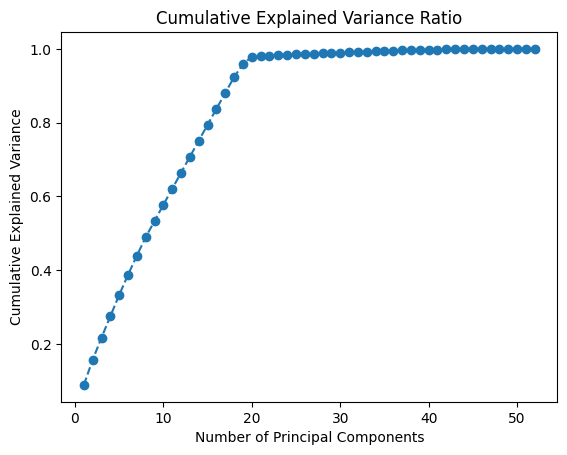

In [85]:
# Plot explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, marker='o' , linestyle='--')
plt.title('Cumulative Explained Variance Ratio') 
plt.xlabel('Number of Principal Components') 
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [86]:
# Determine the optimal number of components based on the explained variance
n_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
print(f"Number of components to retain 95% variance: {n_components}")

Number of components to retain 95% variance: 19


<hr>
<div style="font-family: Calibri; background-color: #faedcd; padding: 5px 5px 5px 5px;">
    <h2>3. LogistisRegression</h2>
</div>

In [87]:
pipeline = Pipeline([
    ('pca', PCA(n_components=n_components)),  # Reduce dimensions using PCA
    ('classifier', LogisticRegression(C = 0.1, random_state=42))  # Train Logistic Regression model
])

In [88]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=19)),
                ('classifier', LogisticRegression(C=0.1, random_state=42))])

In [89]:
train_acc = pipeline.score(X_train, y_train)
test_acc = pipeline.score(X_test, y_test)

print(f'{"Training Accuracy:":<20}{train_acc:.2f}')
print(f'{"Test Accuracy:":<20}{test_acc:.2f}')

y_test_pred = pipeline.predict(X_test)
print(f'{"Recall Score:":<20}{recall_score(y_test, y_test_pred, pos_label=1):.2f}')
print(f'{"Precision Score:":<20}{precision_score(y_test, y_test_pred, pos_label=1):.2f}')
print(f'{"RoC AuC Score:":<20}{roc_auc_score(y_test, y_test_pred):.2f}')
f1 = f1_score(y_test, y_test_pred, pos_label=1)
print(f'{"F1 Score:":<20}{f1:.2}')

Training Accuracy:  0.88
Test Accuracy:      0.88
Recall Score:       0.01
Precision Score:    0.12
RoC AuC Score:      0.50
F1 Score:           0.011


<hr>
<div style="font-family: Calibri; background-color: #faedcd; padding: 5px 5px 5px 5px;">
    <h3>3.1 GridSearchCV</h3>
</div>

In [90]:
params = [
    {     
        "classifier__C": [0.001, 0.01, 0.1, 10, 100],
        "classifier__penalty": ['l1', 'l2'],
        'classifier__solver': ['liblinear'],
    },
    {
        "classifier__C": [ 0.01, 0.1, 10, 100],
        "classifier__penalty": ['l1', 'l2'],
        'classifier__solver': ['lbfgs','newton-cg', 'newton-cholesky']
    },
    {
        "classifier__C": [0.01, 0.1, 10, 100],
        "classifier__penalty": ['l1', 'l2'],
        'classifier__solver': ['liblinear']
    },
    {
        "classifier__C": [0.01, 0.1, 10, 100],
        "classifier__penalty": ['l1', 'l2'],
        'classifier__solver': ['lbfgs','newton-cg', 'newton-cholesky']
    }
]

In [91]:
cv = GridSearchCV(pipeline, param_grid=params, n_jobs=-1, verbose=True, scoring=make_scorer(recall_score, pos_label=1))

In [92]:
cv.fit(X_train, y_train)

Fitting 5 folds for each of 66 candidates, totalling 330 fits


GridSearchCV(estimator=Pipeline(steps=[('pca', PCA(n_components=19)),
                                       ('classifier',
                                        LogisticRegression(C=0.1,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid=[{'classifier__C': [0.001, 0.01, 0.1, 10, 100],
                          'classifier__penalty': ['l1', 'l2'],
                          'classifier__solver': ['liblinear']},
                         {'classifier__C': [0.01, 0.1, 10, 100],
                          'classifier__penalty': ['l1', 'l2'],
                          'classifier__solver':...ton-cg',
                                                 'newton-cholesky']},
                         {'classifier__C': [0.01, 0.1, 10, 100],
                          'classifier__penalty': ['l1', 'l2'],
                          'classifier__solver': ['liblinear']},
                         {'classifier__C': [0.01, 0.1, 10, 100],
                          'classifier__penalty': ['l1', 'l2'],
                          'classifier__solver': ['lbfgs', 'newton-cg',
                                                 'newton-cholesky']}],
             scoring=make_scorer(recall_score, response_method='predict', pos_label=1),
             verbose=True)

In [93]:
print("Best Parameters:", cv.best_params_)
print("Best CV Score:", cv.best_score_)

Best Parameters: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best CV Score: 0.027180973551093335


In [94]:
model = cv.best_estimator_
model

Pipeline(steps=[('pca', PCA(n_components=19)),
                ('classifier',
                 LogisticRegression(C=10, penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [95]:
y_pred = model.predict(X_test)

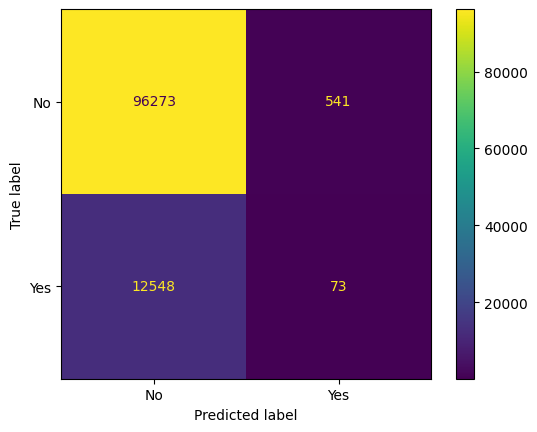

In [96]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format='d', display_labels=["No","Yes"]);

In [97]:
rs = recall_score(y_test, y_pred, pos_label=1)
ps = precision_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)
ac = accuracy_score(y_test, y_pred)

In [98]:
print(f"{'Recall Score:':<20}{rs:<5}")
print(f"{'Precision Score:':<20}{ps:<5}")
print(f"{'F1 Score:':<20}{f1:<5}")
print(f"{'Accuracy Score:':<20}{ac:<5}")

Recall Score:       0.005784010775691308
Precision Score:    0.11889250814332247
F1 Score:           0.011031356252361164
Accuracy Score:     0.8803947548773244


In [99]:
y_train_pred_prob, y_test_pred_prob = calc_predict_proba(model, X_train, y_train, X_test, y_test)

In [100]:
rs_list, ps_list, f1_list, ac_list = [],[],[],[]
for thresh in np.arange(0.3,0.8,0.1):
    rs, ps, f1, ac, y_test_pred = calc_scores(model, X_train, y_train, y_train_pred_prob, X_test, y_test, y_test_pred_prob, thresh)
    rs_list.append(rs) 
    ps_list.append(ps)
    f1_list.append(f1)
    ac_list.append(ac)

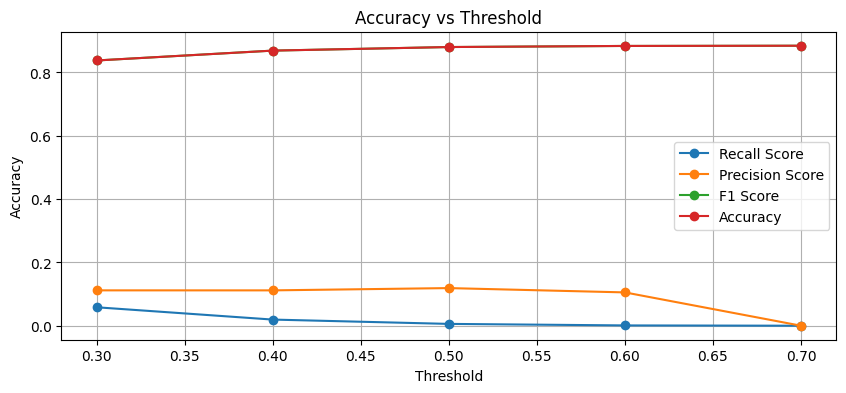

In [101]:
plt.figure(figsize=(10, 4))

plt.plot(np.arange(0.3,0.8,0.1), rs_list, label='Recall Score', marker='o')
plt.plot(np.arange(0.3,0.8,0.1), ps_list, label='Precision Score', marker='o')
plt.plot(np.arange(0.3,0.8,0.1), f1_list, label='F1 Score', marker='o')
plt.plot(np.arange(0.3,0.8,0.1), ac_list, label='Accuracy', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

<hr>
<div style="font-family: Calibri; background-color: #faedcd; padding: 5px 5px 5px 5px;">
    <h2>3. Ensemble</h2>
</div>

In [102]:
from catboost import CatBoostClassifier

In [103]:
pipeline = Pipeline([
    ('pca', PCA(n_components=n_components)),  # Reduce dimensions using PCA
    ('model', CatBoostClassifier(class_weights={0:1, 1:9}, random_state=42, verbose=0))  # Train Logistic Regression model
])

In [104]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=19)),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x7f318317d9d0>)])

In [105]:
train_acc = pipeline.score(X_train, y_train)
test_acc = pipeline.score(X_test, y_test)

print(f'{"Training Accuracy:":<20}{train_acc:.2f}')
print(f'{"Test Accuracy:":<20}{test_acc:.2f}')

y_test_pred = pipeline.predict(X_test)
print(f'{"Recall Score:":<20}{recall_score(y_test, y_test_pred, pos_label=1):.2f}')
print(f'{"Precision Score:":<20}{precision_score(y_test, y_test_pred, pos_label=1):.2f}')
print(f'{"RoC AuC Score:":<20}{roc_auc_score(y_test, y_test_pred):.2f}')
f1 = f1_score(y_test, y_test_pred, pos_label=1)
print(f'{"F1 Score:":<20}{f1:.2}')

Training Accuracy:  0.71
Test Accuracy:      0.60
Recall Score:       0.36
Precision Score:    0.11
RoC AuC Score:      0.50
F1 Score:           0.17


In [111]:
y_pred = pipeline.predict(X_test)

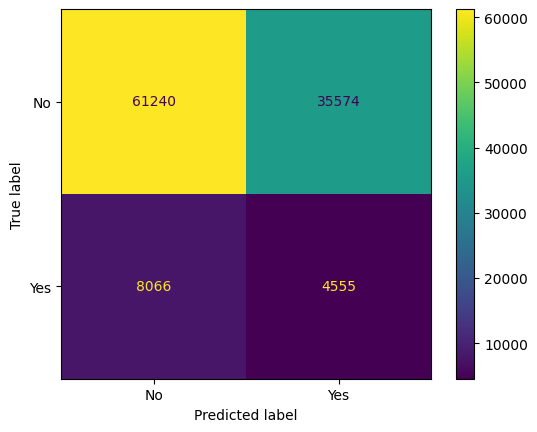

In [112]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format='d', display_labels=["No","Yes"]);

In [113]:
y_train_pred_prob, y_test_pred_prob = calc_predict_proba(model, X_train, y_train, X_test, y_test)

In [114]:
rs_list, ps_list, f1_list, ac_list = [],[],[],[]
for thresh in np.arange(0.3,0.8,0.1):
    rs, ps, f1, ac, y_test_pred = calc_scores(model, X_train, y_train, y_train_pred_prob, X_test, y_test, y_test_pred_prob, thresh)
    rs_list.append(rs) 
    ps_list.append(ps)
    f1_list.append(f1)
    ac_list.append(ac)

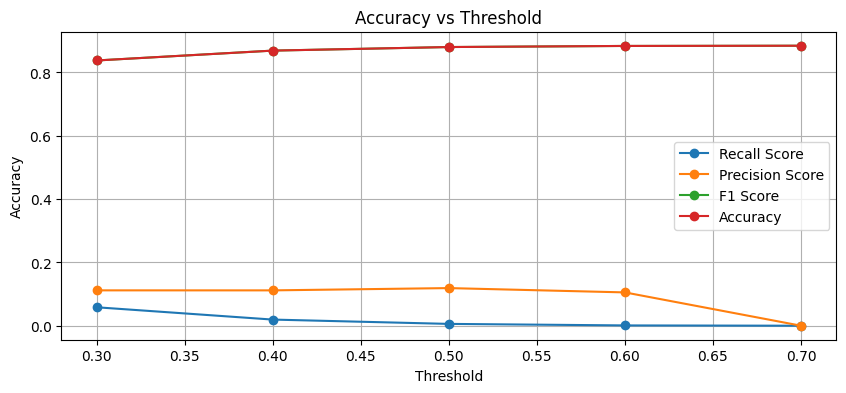

In [115]:
plt.figure(figsize=(10, 4))

plt.plot(np.arange(0.3,0.8,0.1), rs_list, label='Recall Score', marker='o')
plt.plot(np.arange(0.3,0.8,0.1), ps_list, label='Precision Score', marker='o')
plt.plot(np.arange(0.3,0.8,0.1), f1_list, label='F1 Score', marker='o')
plt.plot(np.arange(0.3,0.8,0.1), ac_list, label='Accuracy', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Threshold')
plt.legend()
plt.grid(True)
plt.show()